In [ ]:
!pip install -q transformers datasets scikit-learn

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

from datasets import load_dataset
from transformers import AutoTokenizer, GPT2ForSequenceClassification
from transformers import DataCollatorWithPadding, get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
# ==========================
# Config
# ==========================
model_name = "gpt2"
num_epochs = 5
batch_size = 16
max_length = 256
learning_rate = 5e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# ==========================
# Load dataset (SST-2)
# ==========================
dataset = load_dataset("glue", "sst2")

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def preprocess(batch):
    enc = tokenizer(
        batch["sentence"],
        truncation=True,
        max_length=max_length,
    )
    enc["labels"] = batch["label"]
    return enc

encoded = dataset.map(preprocess, batched=True)
encoded = encoded.remove_columns(["sentence", "label", "idx"])

data_collator = DataCollatorWithPadding(tokenizer, padding=True)

encoded.set_format(type="torch")

train_dataloader = DataLoader(
    encoded["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

val_dataloader = DataLoader(
    encoded["validation"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
# ==========================
# Model, optimizer, scheduler
# ==========================
model = GPT2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
)
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ==========================
# Training loop (5 epochs)
# ==========================
train_losses = []
val_accuracies = []
val_f1s = []

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    total_loss = 0.0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            labels = batch["labels"].to(device)
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    val_acc = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)

    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)


    print("\n" + "_" * 50)
    print(f"EPOCH {epoch}")
    print("_" * 50)
    print(f"Train {epoch}: 100%")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation F1: {val_f1:.4f}")
    print("_" * 50)


__________________________________________________
EPOCH 0
__________________________________________________
Train 0: 100%
Train Loss: 0.2665
Validation Accuracy: 0.9060
Validation F1: 0.9097
__________________________________________________

__________________________________________________
EPOCH 1
__________________________________________________
Train 1: 100%
Train Loss: 0.1415
Validation Accuracy: 0.9014
Validation F1: 0.9047
__________________________________________________

__________________________________________________
EPOCH 2
__________________________________________________
Train 2: 100%
Train Loss: 0.0918
Validation Accuracy: 0.9083
Validation F1: 0.9115
__________________________________________________

__________________________________________________
EPOCH 3
__________________________________________________
Train 3: 100%
Train Loss: 0.0572
Validation Accuracy: 0.9117
Validation F1: 0.9136
__________________________________________________

___________________

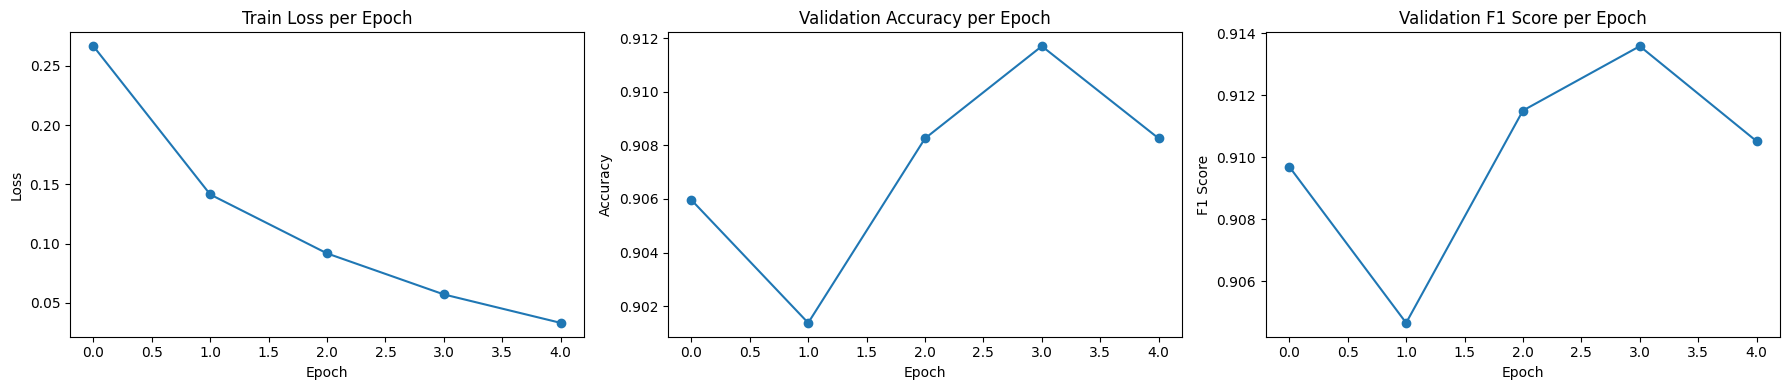

In [ ]:
# ==========================
# Plots
# ==========================
epochs = list(range(num_epochs))

plt.figure(figsize=(18, 4))

# Train loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker="o")
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Validation accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accuracies, marker="o")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Validation F1
plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1s, marker="o")
plt.title("Validation F1 Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()